# Benchmark dataset plots

This notebook contains the code used to produce the plots from Sections 3.1 & 3.2 of the paper

**The assumption is that the `../data/<choice for k>/<dataset>_results.csv` files have been generated for both choices of $k$.**

**This is done by running the following notebooks:**
- **`summarise_datasets.ipynb` (if `../data/knee/<dataset>_costs.csv` do not exist)**
- **`knee_data.ipynb` and `nclasses_data.ipynb`.**

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
plt.style.use("seaborn-colorblind")
warnings.filterwarnings("ignore")

In [2]:
method_colours = {"cao": "tab:green", "huang": "tab:blue", "matching": "tab:orange"}


# Plotting results and results tables


In [3]:
def empirical_cdf_plots(name, root, column, filename, nseeds=None):

    """ Plot the CDF of either the initial or final cost for an initialisation
    method. This is controlled via the `column` argument. """

    results = pd.read_csv(f"{root}{name}_results.csv")
    if nseeds:
        results = results[results["seed"] < nseeds]

    xmin = results[["initial_cost", "final_cost"]].min().min() * 0.99
    xmax = results[["initial_cost", "final_cost"]].max().max() * 1.01

    fig, ax = plt.subplots(figsize=(5, 2.5), dpi=300)

    for group, values in results.groupby("initialisation"):
        colour = method_colours[group]
        if group == "cao":
            ax.vlines(
                x=values[column].median(),
                ymin=0,
                ymax=1.1,
                color=colour,
                label=group.capitalize(),
            )
        else:
            histtype, alpha = "bar", 0.25
            if group == "huang":
                histtype, alpha = "bar", 0.25

            ax.hist(
                values[column],
                cumulative=True,
                bins=100,
                density=True,
                color=colour,
                histtype=histtype,
                alpha=alpha,
                label=group.capitalize(),
            )

        separated_column = " ".join(column.split("_"))
        ax.set_xlabel(separated_column.capitalize())
        ax.set_ylabel("Likelihood of observation")

        ax.set_ylim(0, 1.05)
        ax.set_xlim(xmin, xmax)

        ax.legend()
        plt.tight_layout()

        if filename is not None:
            plt.savefig(filename, transparent=True)


In [4]:
def scatter_plots(name, root, filename, nseeds=None):

    """ Generate a scatter plot of initial cost vs. final cost. """

    results = pd.read_csv(f"{root}{name}_results.csv")
    if nseeds:
        results = results[results["seed"] < nseeds]

    fig, ax = plt.subplots(figsize=(5, 5), dpi=300)

    for group, values in results.groupby("initialisation"):
        colour = method_colours[group]
        alpha, zorder, marker, markersize, edgecolour = 0.75, 1, ".", 100, "None"
        if group == "cao":
            alpha, zorder, marker = 1, 2, "x"
        if group == "huang":
            marker, markersize, colour = "D", 25, colour

        ax.scatter(
            values["initial_cost"],
            values["final_cost"],
            alpha=alpha,
            zorder=zorder,
            marker=marker,
            s=markersize,
            edgecolor=edgecolour,
            facecolor=colour,
            label=group.capitalize(),
        )

    ax.set_xlabel("Initial cost")
    ax.set_ylabel("Final cost")

    limits = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]

    ax.plot(limits, limits, "gray", alpha=0.5, zorder=0)

    ax.set_aspect("equal")
    ax.set_xlim(limits)
    ax.set_ylim(limits)

    ax.legend()
    plt.tight_layout()

    if filename is not None:
        plt.savefig(filename, transparent=True)


In [5]:
def get_summary(name, root, filename, nseeds=None):

    results = pd.read_csv(f"{root}{name}_results.csv")
    if nseeds:
        results = results[results["seed"] < nseeds]

    means = results.groupby("initialisation")[
        ["initial_cost", "final_cost", "n_iterations", "time"]
    ].mean()

    stds = results.groupby("initialisation")[
        ["initial_cost", "final_cost", "n_iterations", "time"]
    ].std()

    summary = pd.DataFrame(columns=means.columns, index=means.index)
    for j, column in enumerate(means):
        for i, _ in enumerate(means[column]):
            summary.iloc[i, j] = f"{means.iloc[i, j]:.2f} ({stds.iloc[i, j]:.3f})"

    summary.columns = ["Initial cost", "Final cost", "No. iterations", "Time"]
    summary.index = ["Cao", "Huang", "Matching"]

    if filename is not None:
        summary.to_latex(filename)


In [6]:
def make_plots(root, tshift, fshift):

    for i, name in enumerate(("breast_cancer", "mushroom", "nursery", "soybean")):
        table_num, figure_num = i + tshift, i + fshift

        get_summary(name, root, filename=f"../tex/Tab{table_num}.tex", nseeds=nseeds)
        scatter_plots(name, root, filename=f"../img/Fig{figure_num}a.pdf", nseeds=nseeds)
        empirical_cdf_plots(name, root, "initial_cost", filename=f"../img/Fig{figure_num}b1.pdf", nseeds=nseeds)
        empirical_cdf_plots(name, root, "final_cost", filename=f"../img/Fig{figure_num}b2.pdf", nseeds=nseeds)

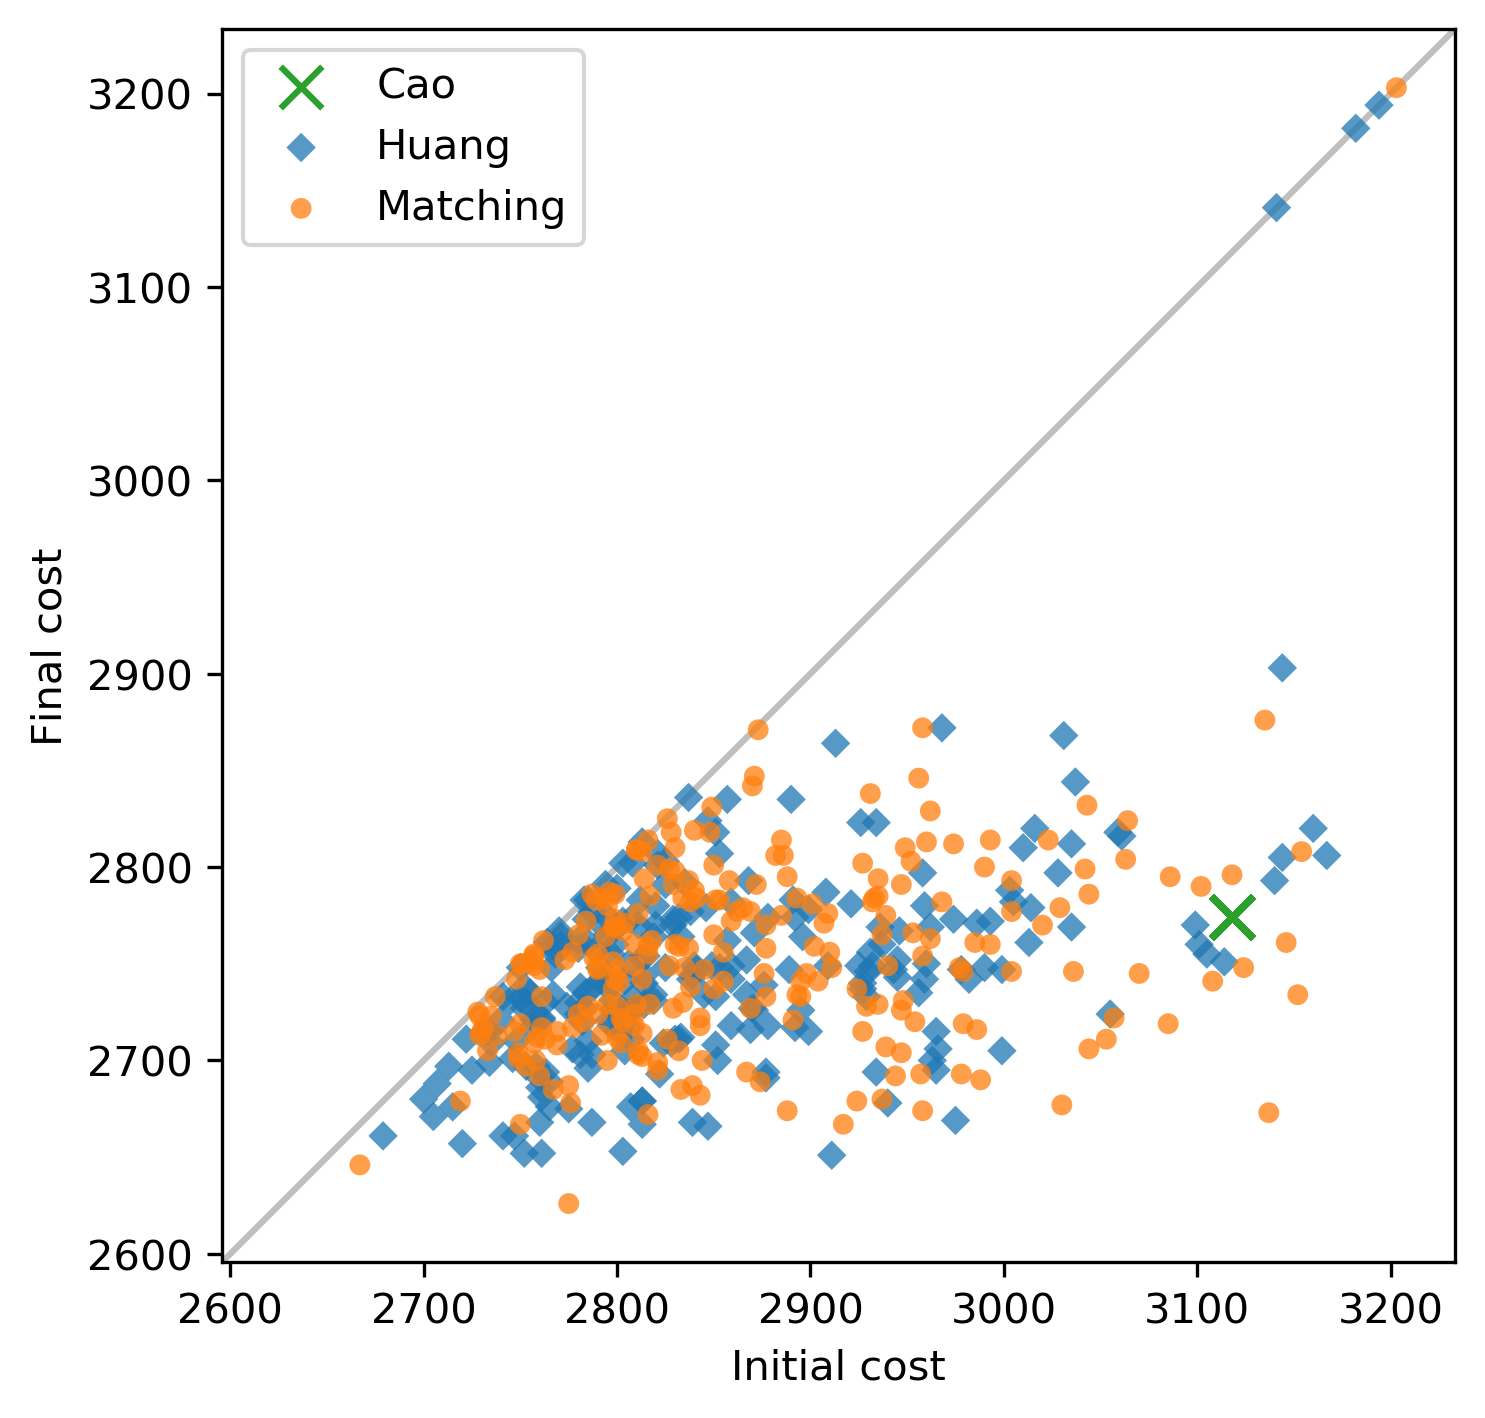

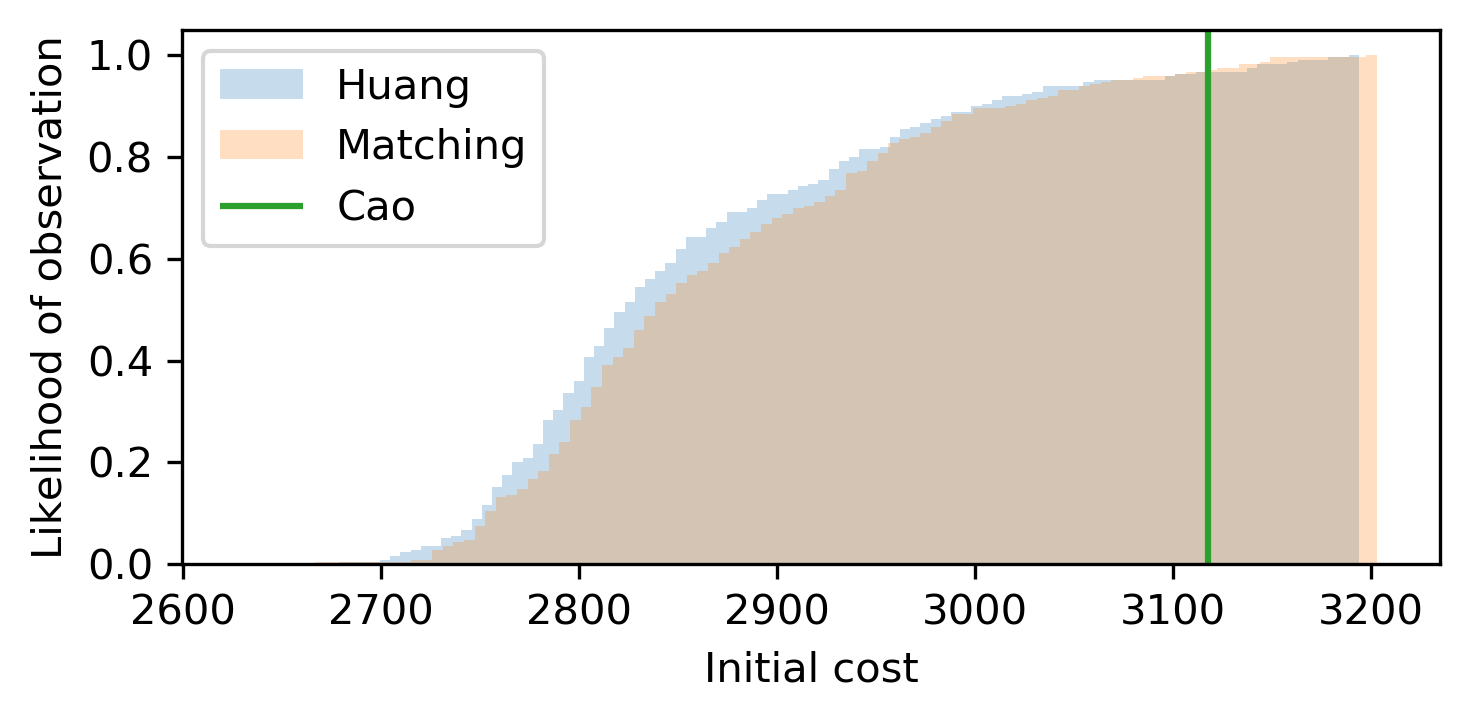

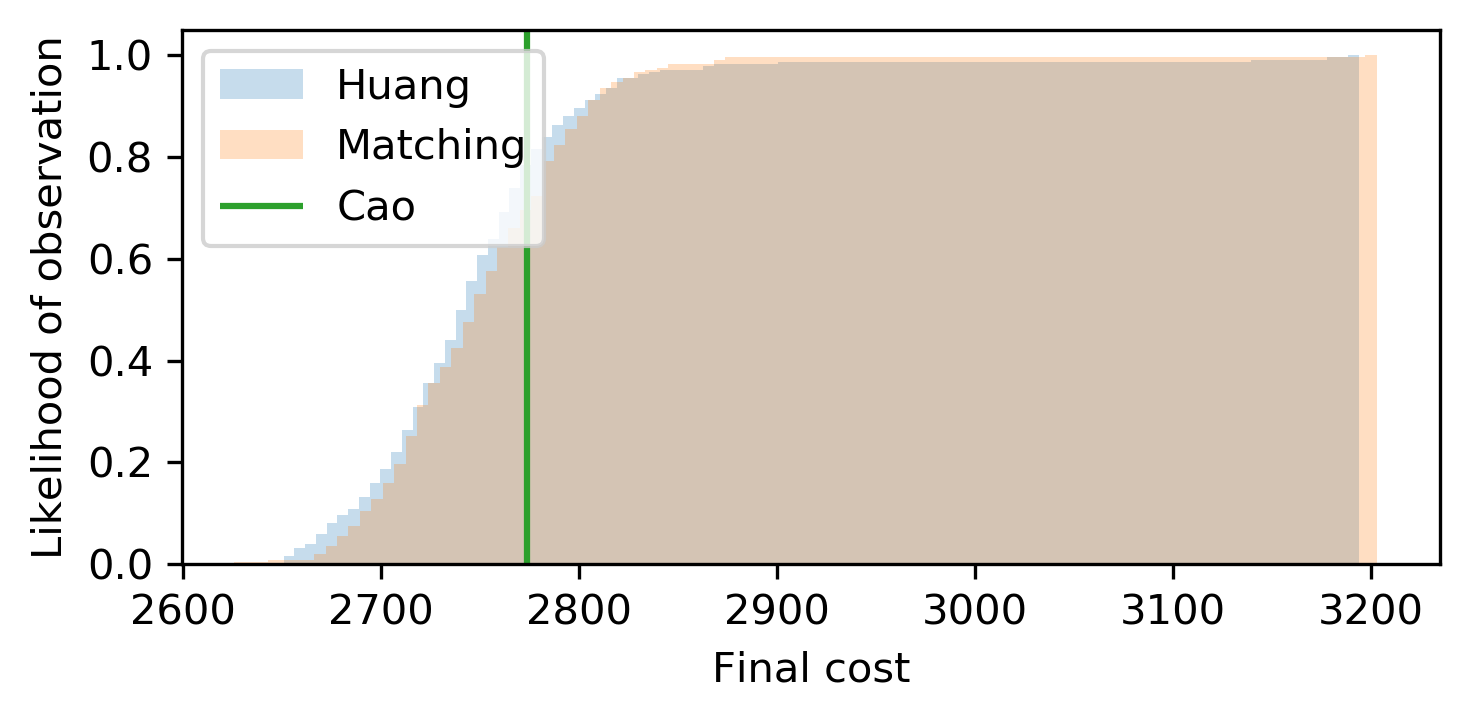

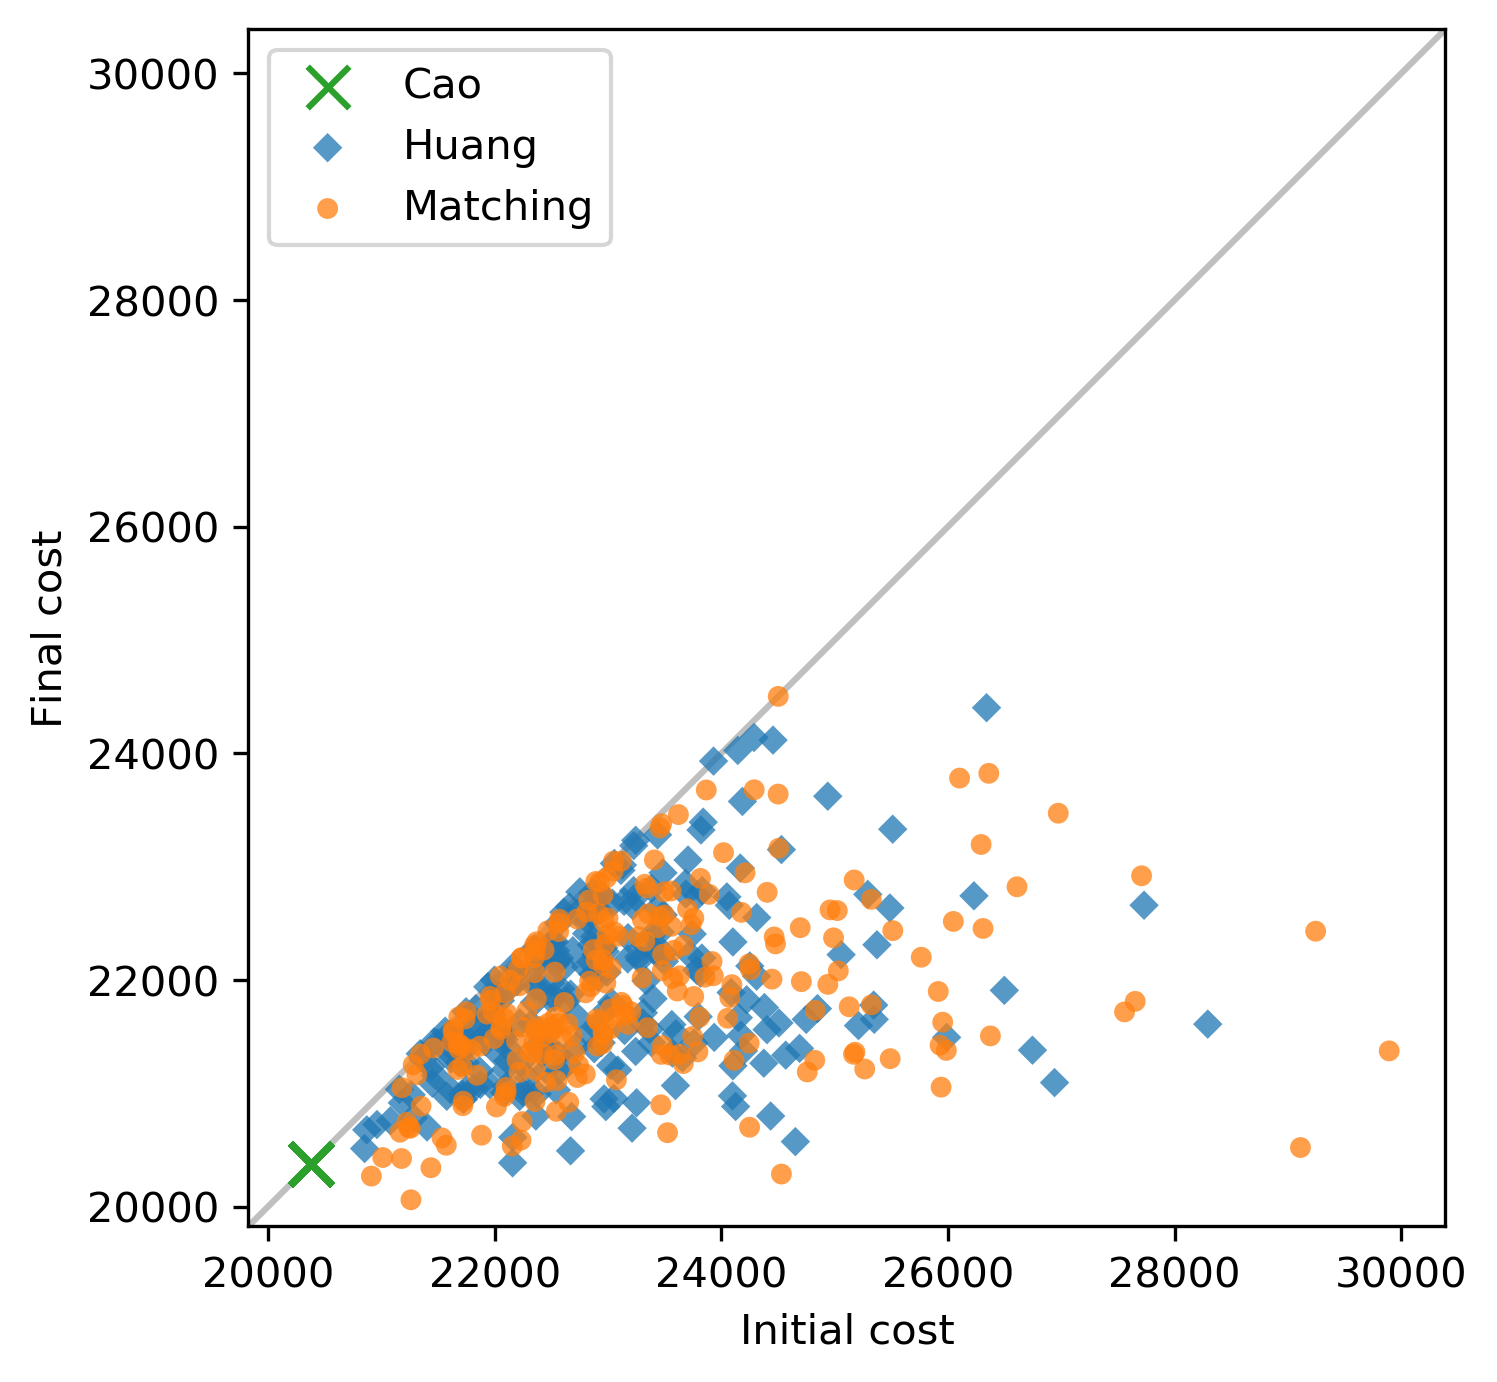

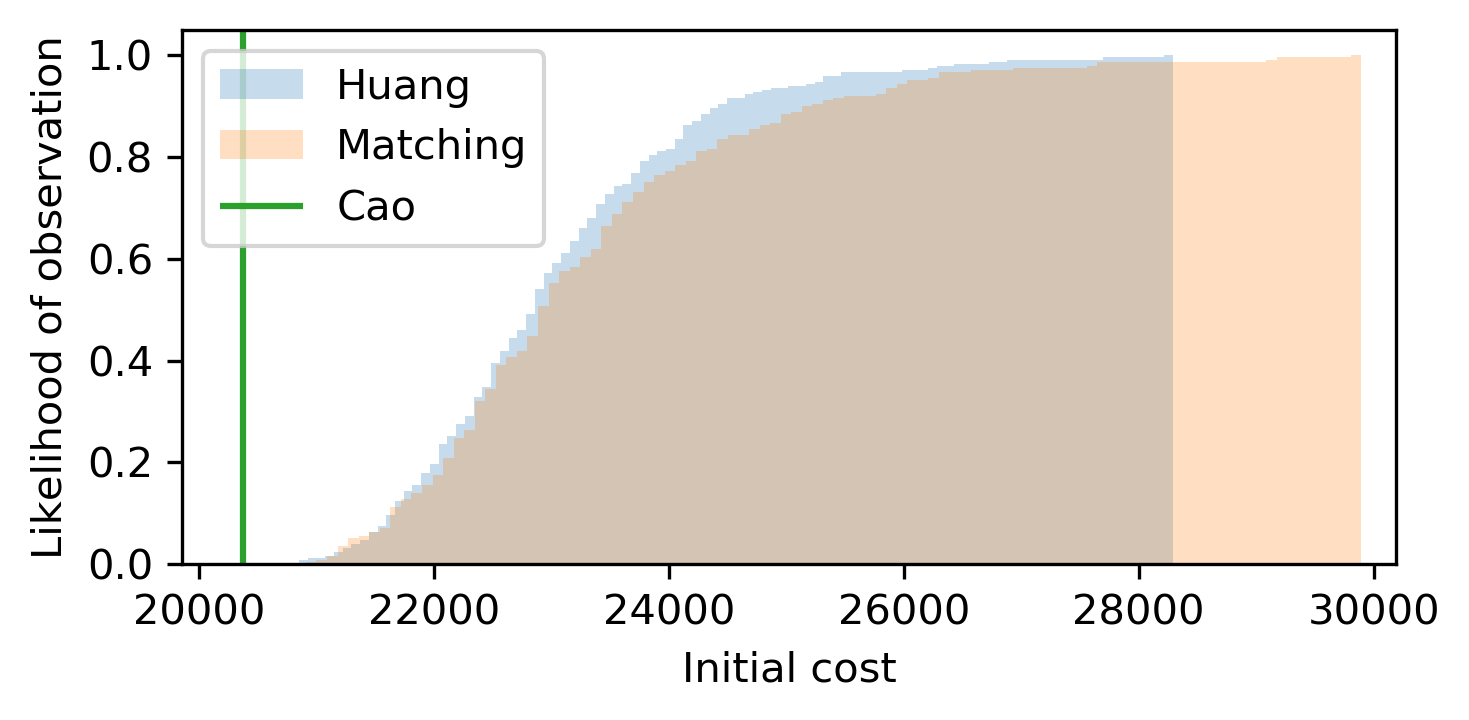

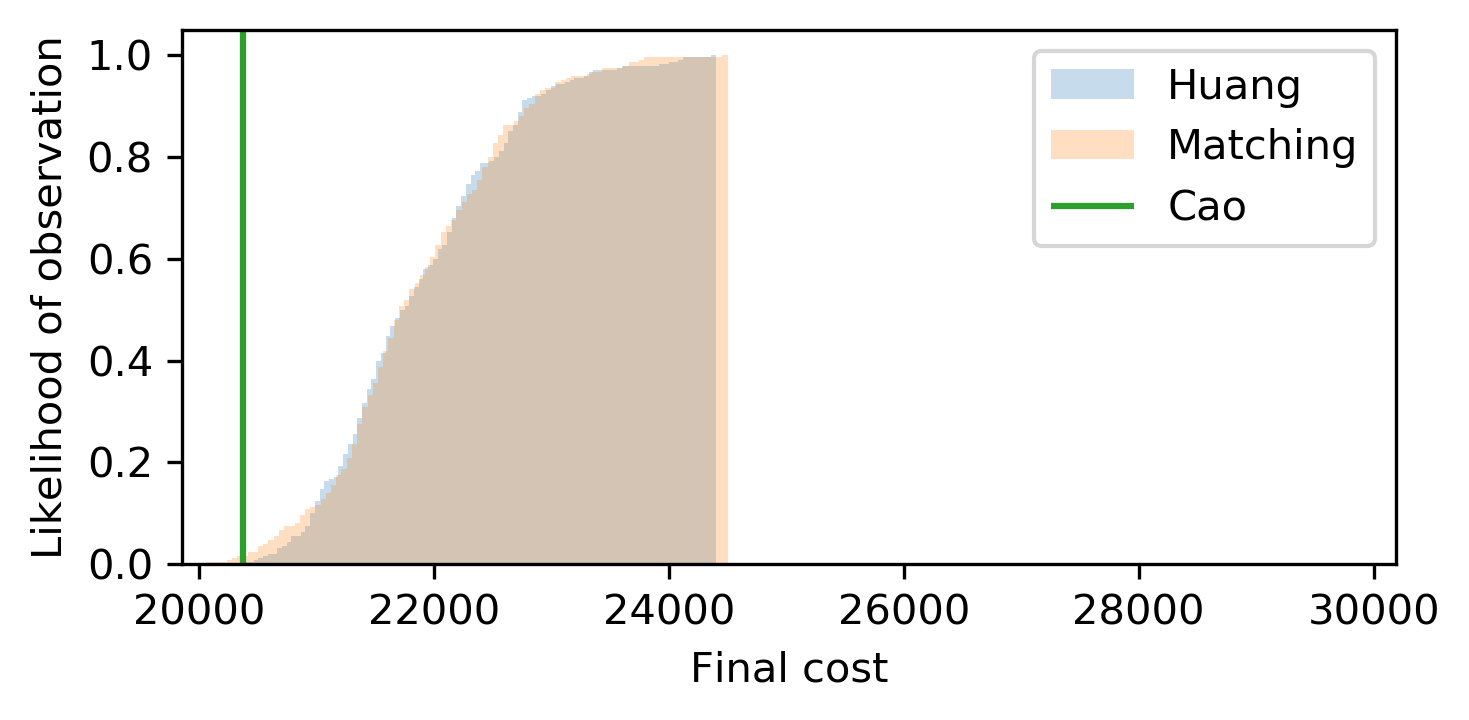

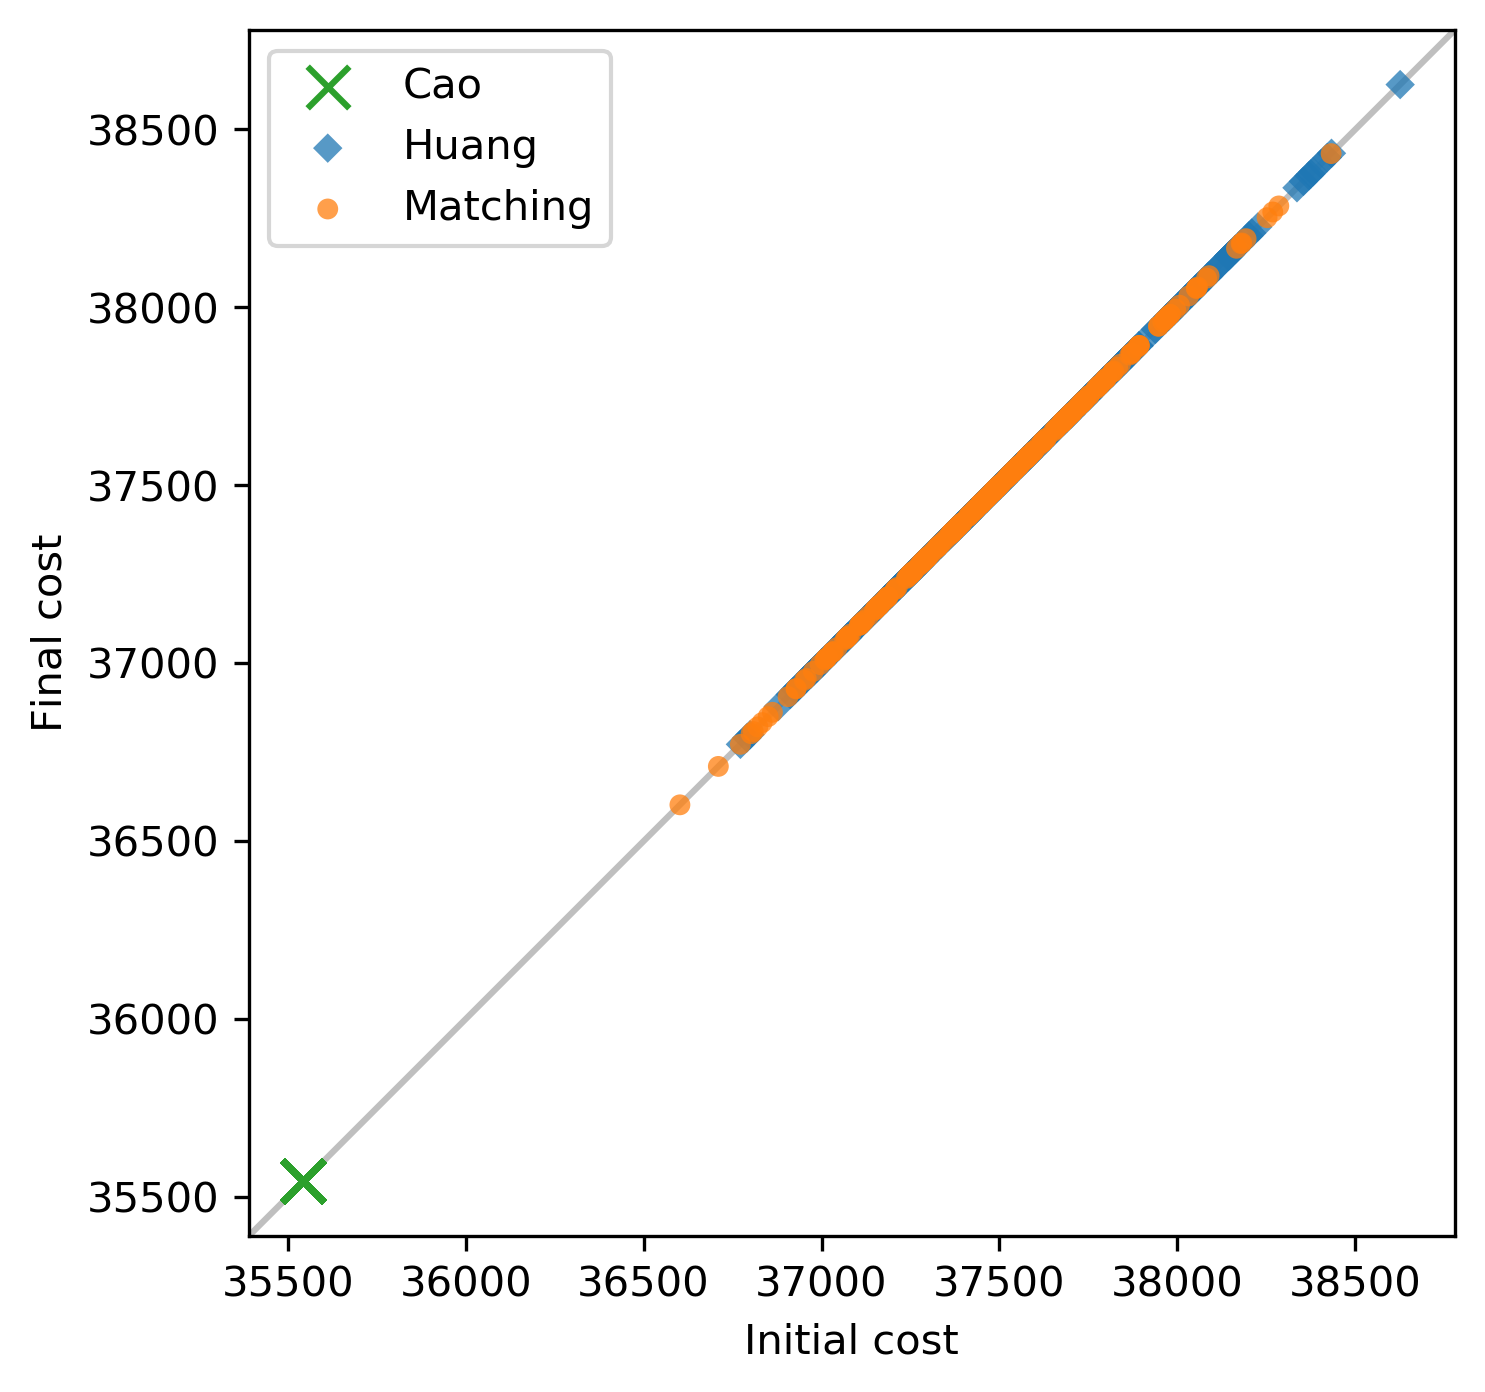

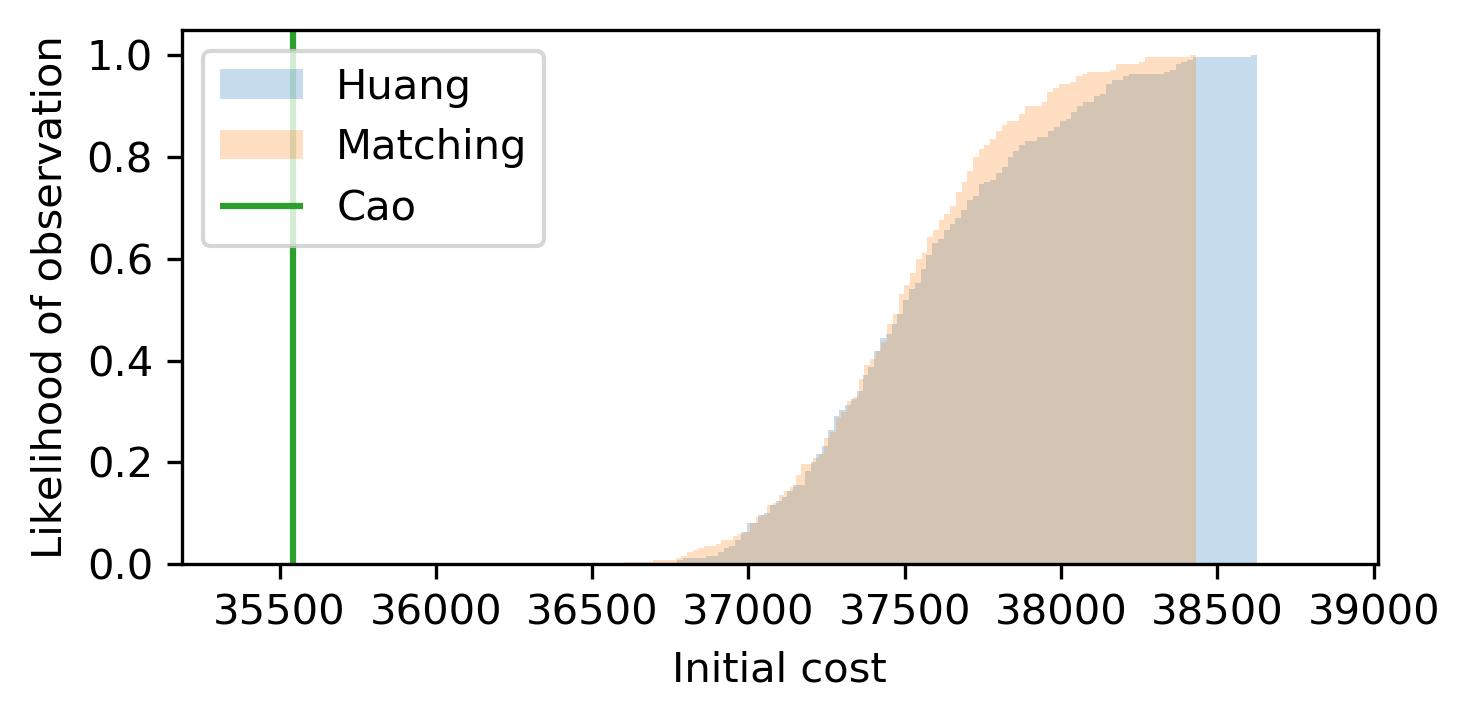

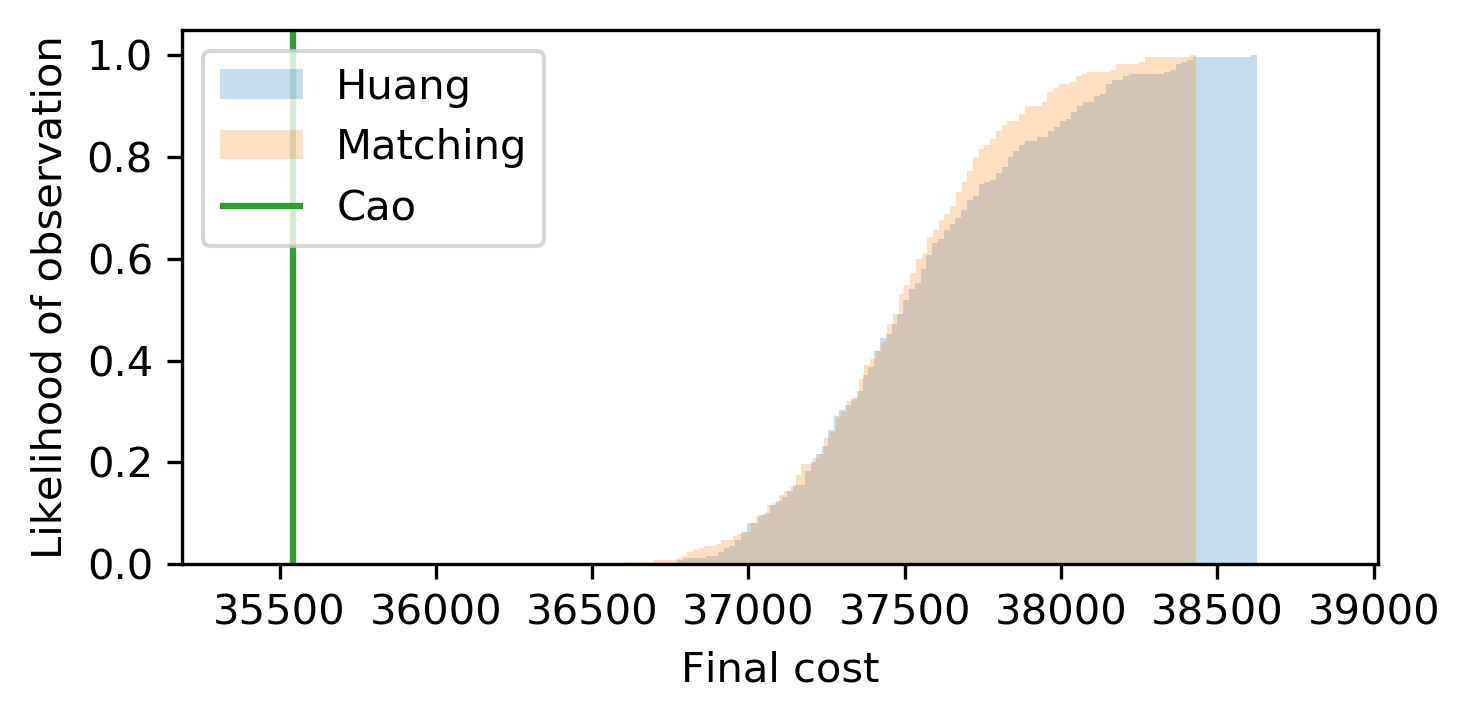

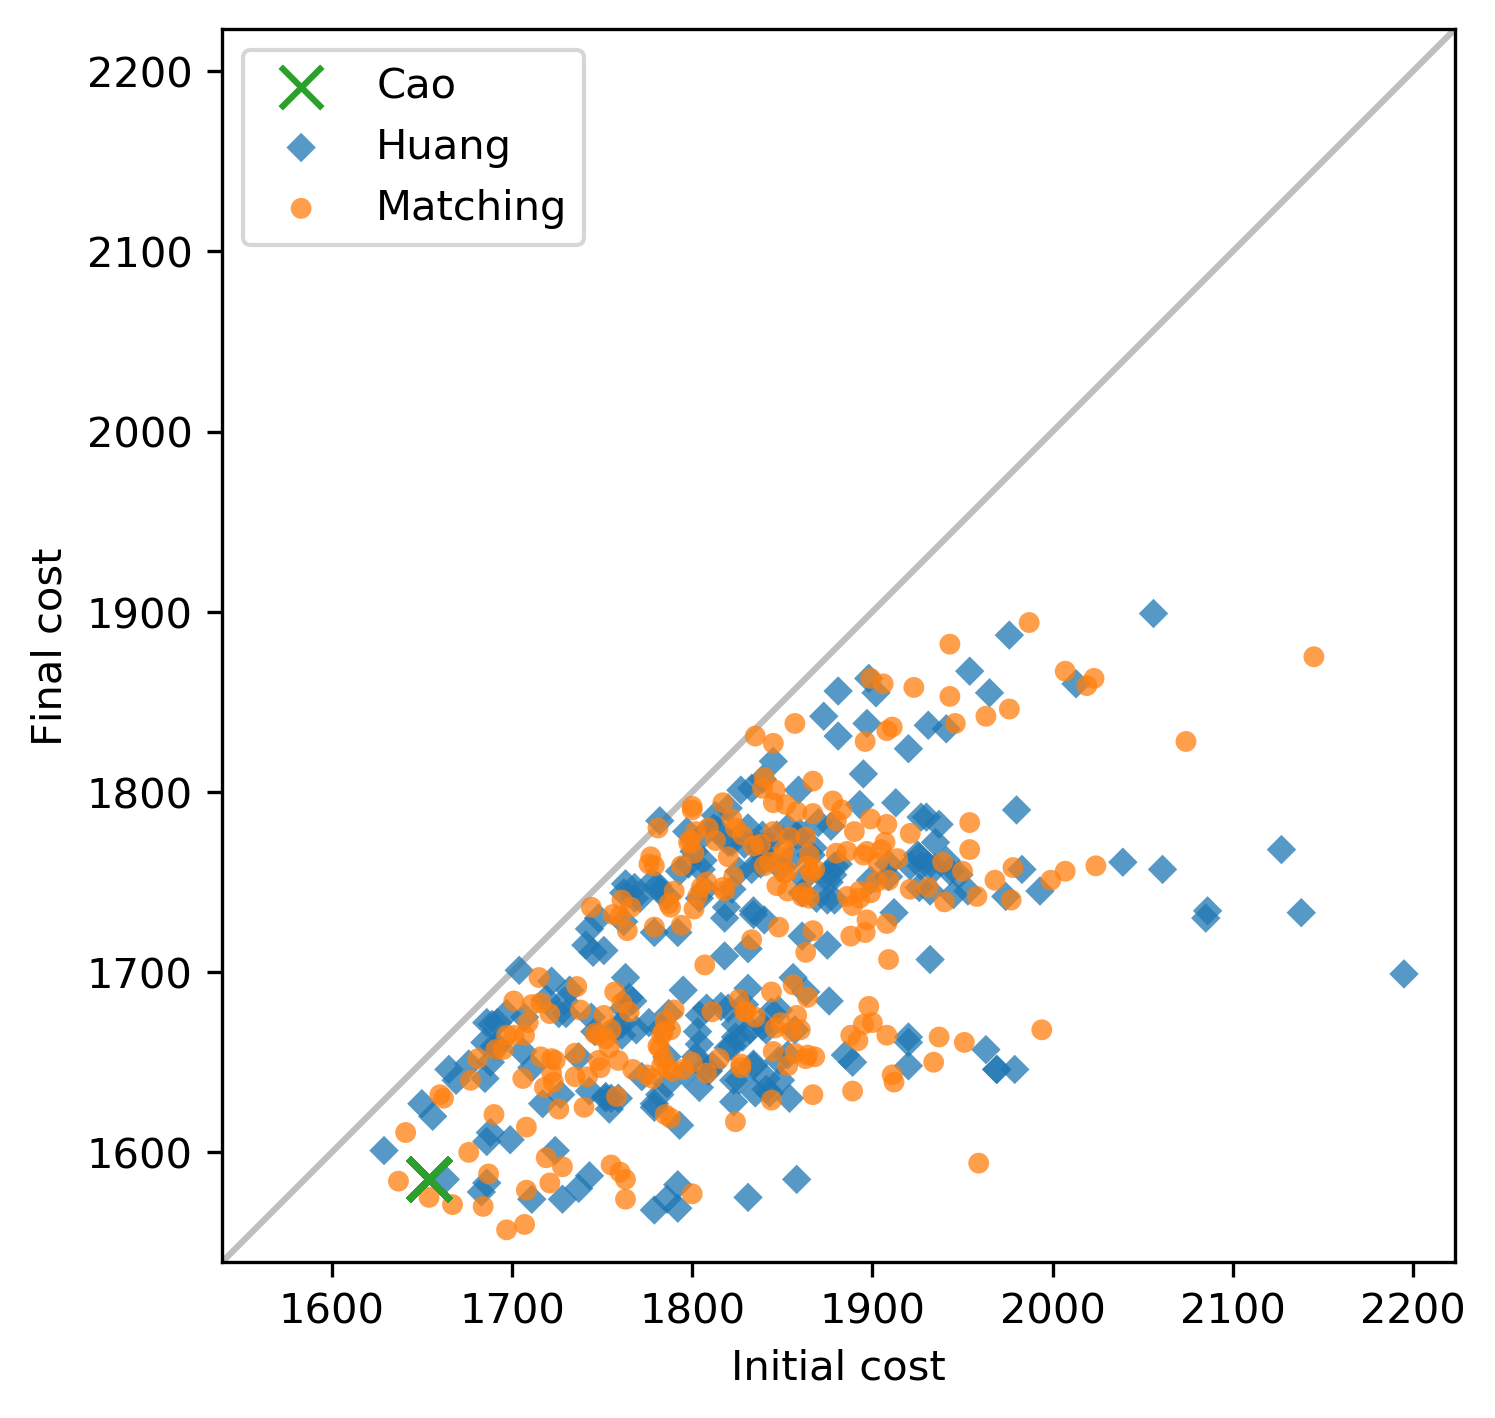

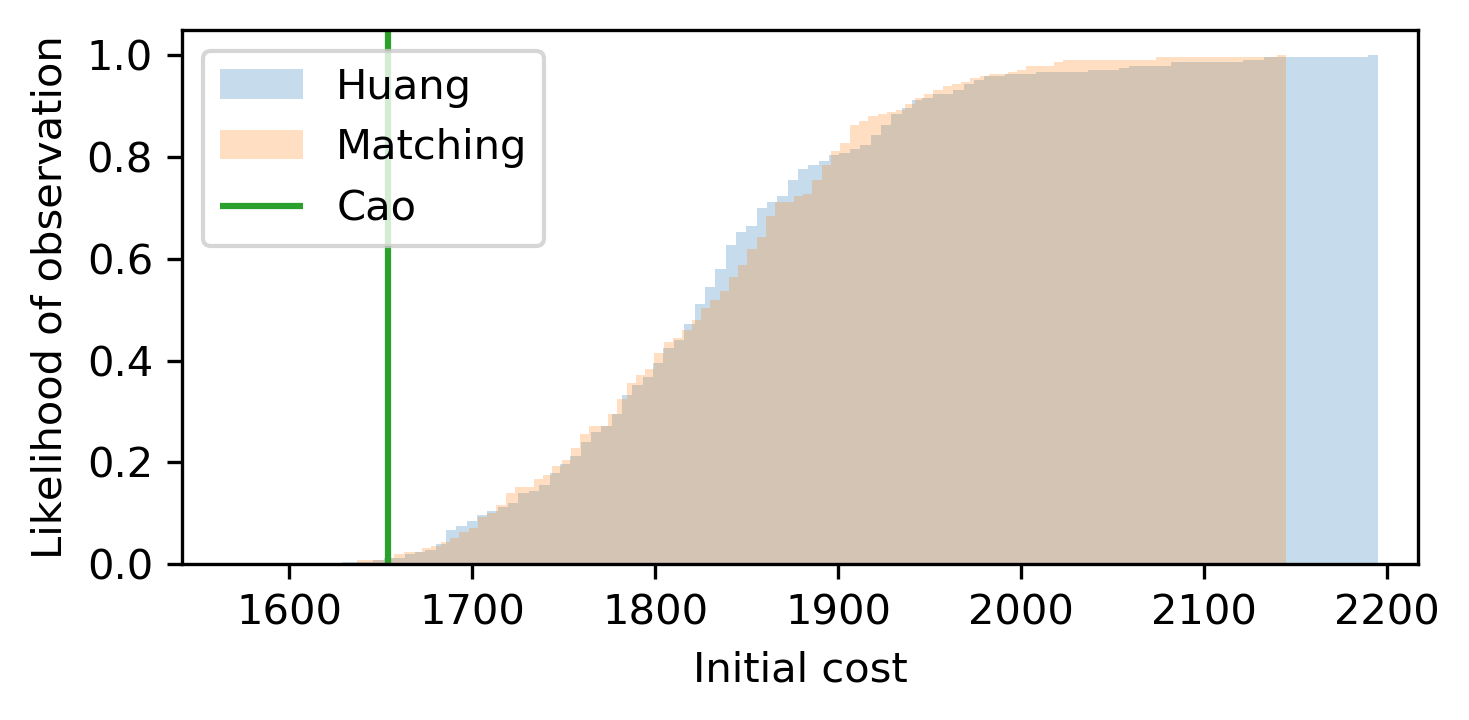

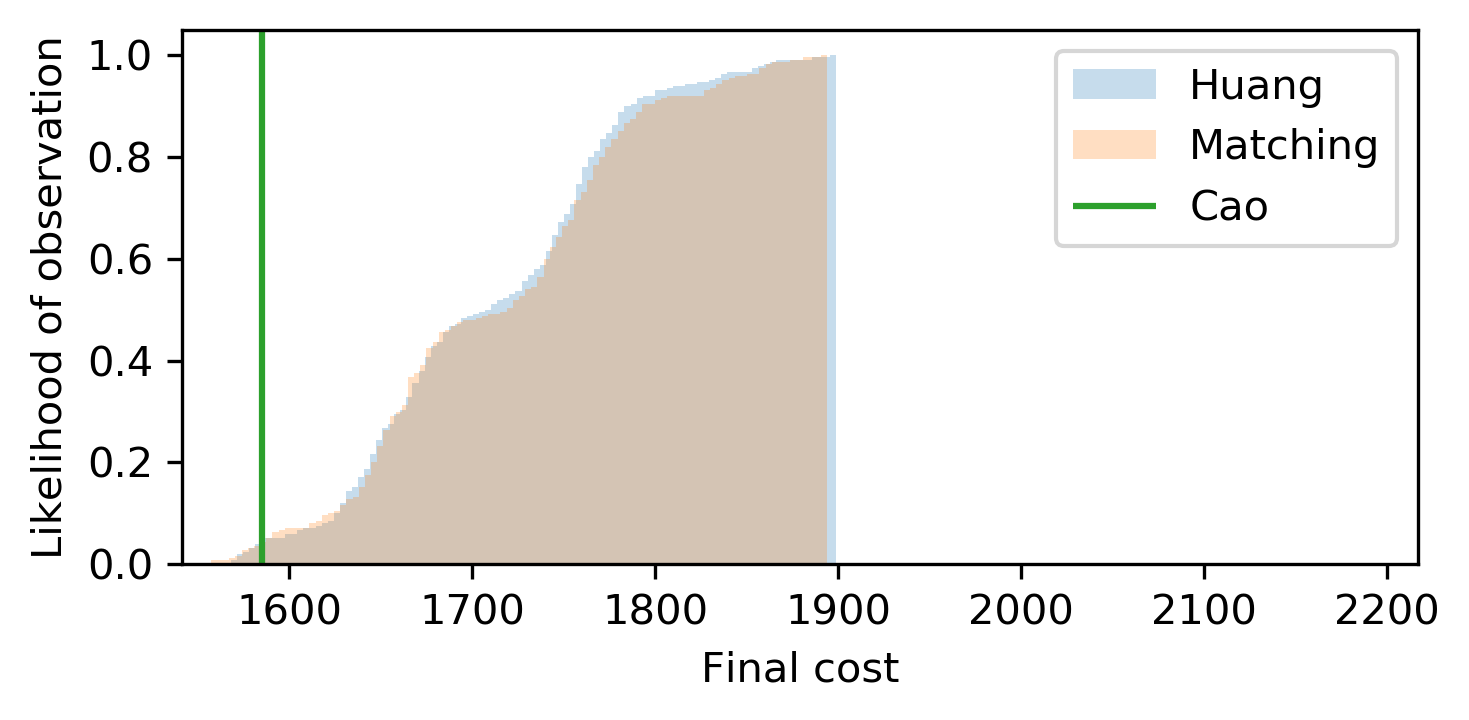

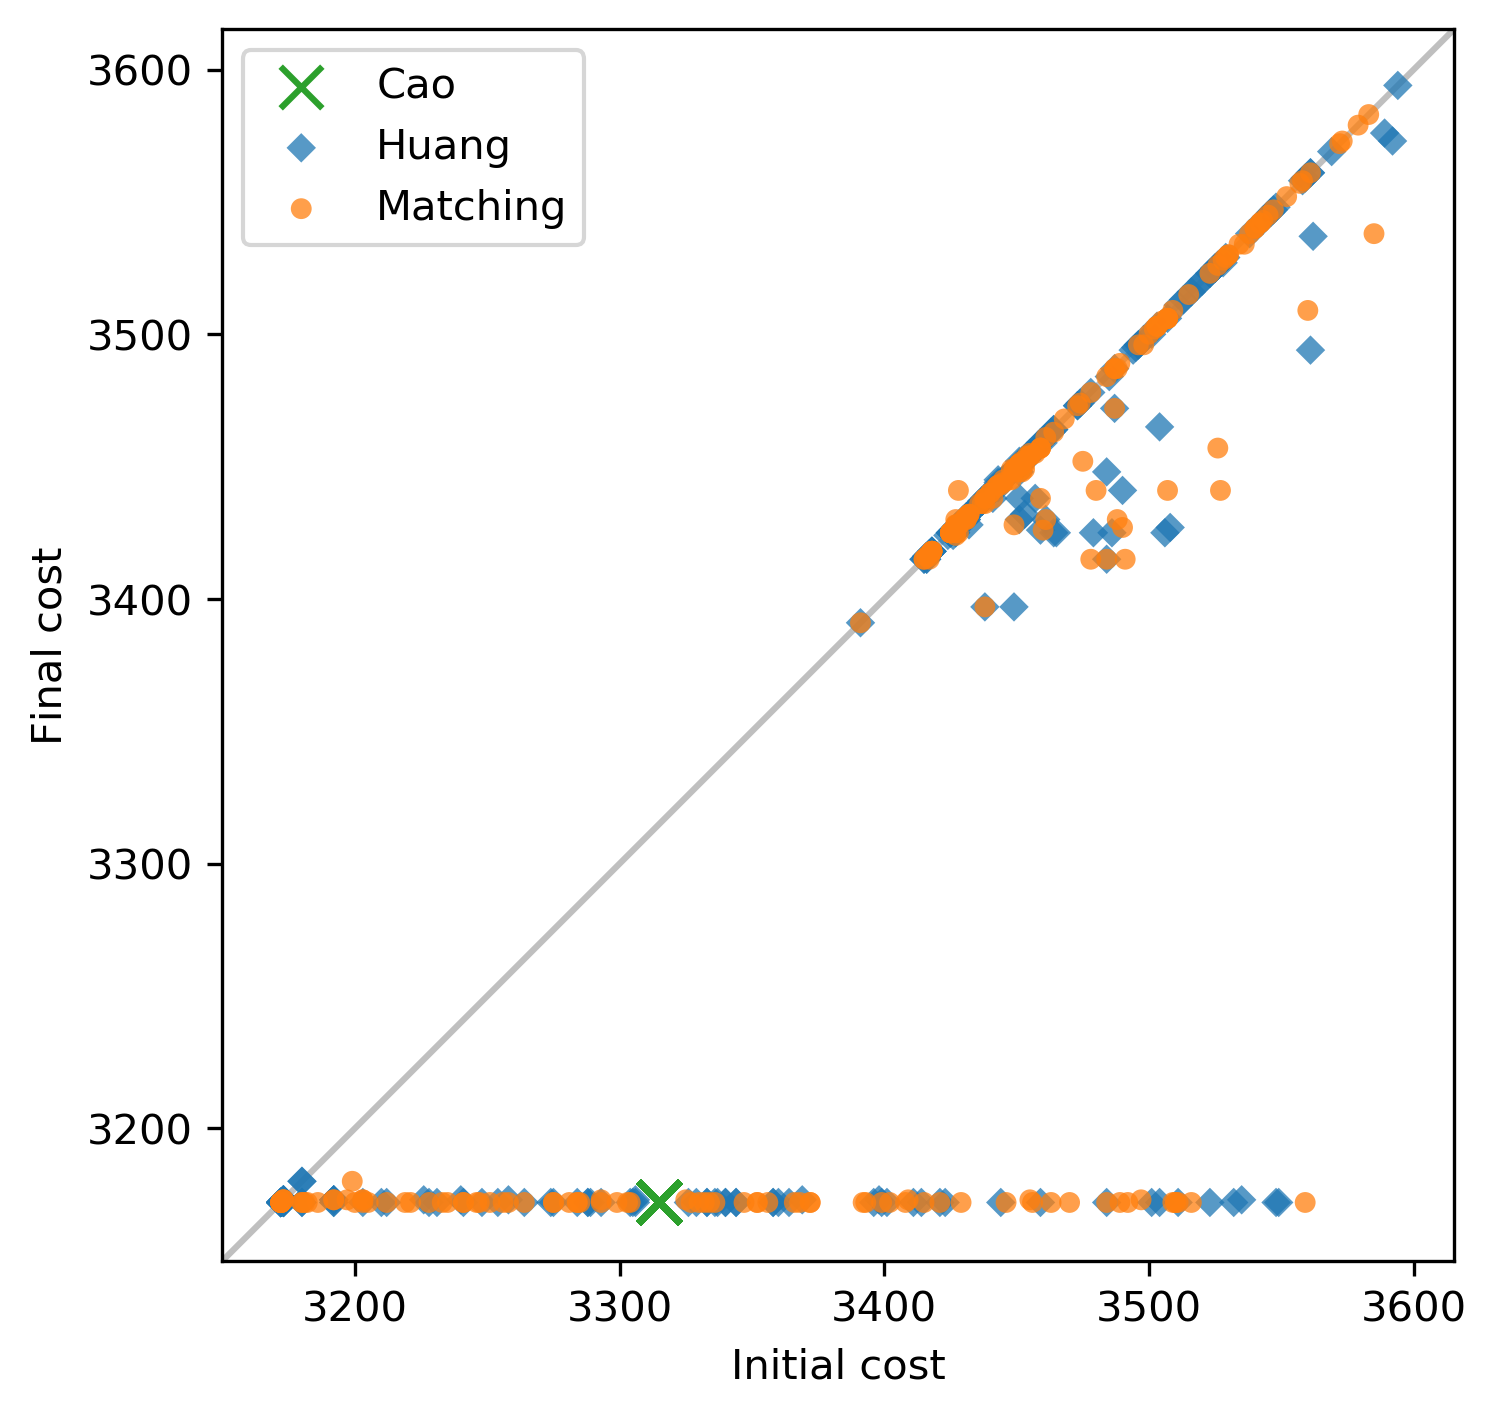

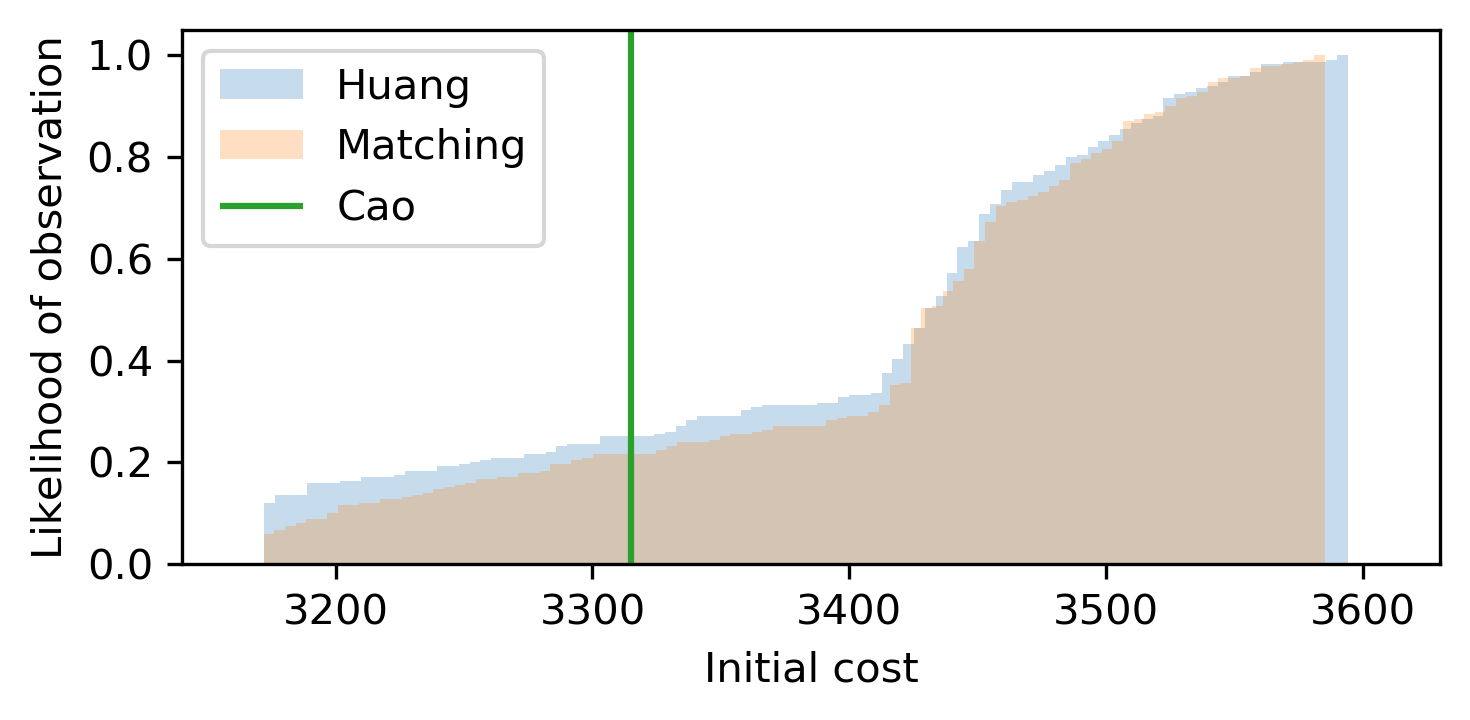

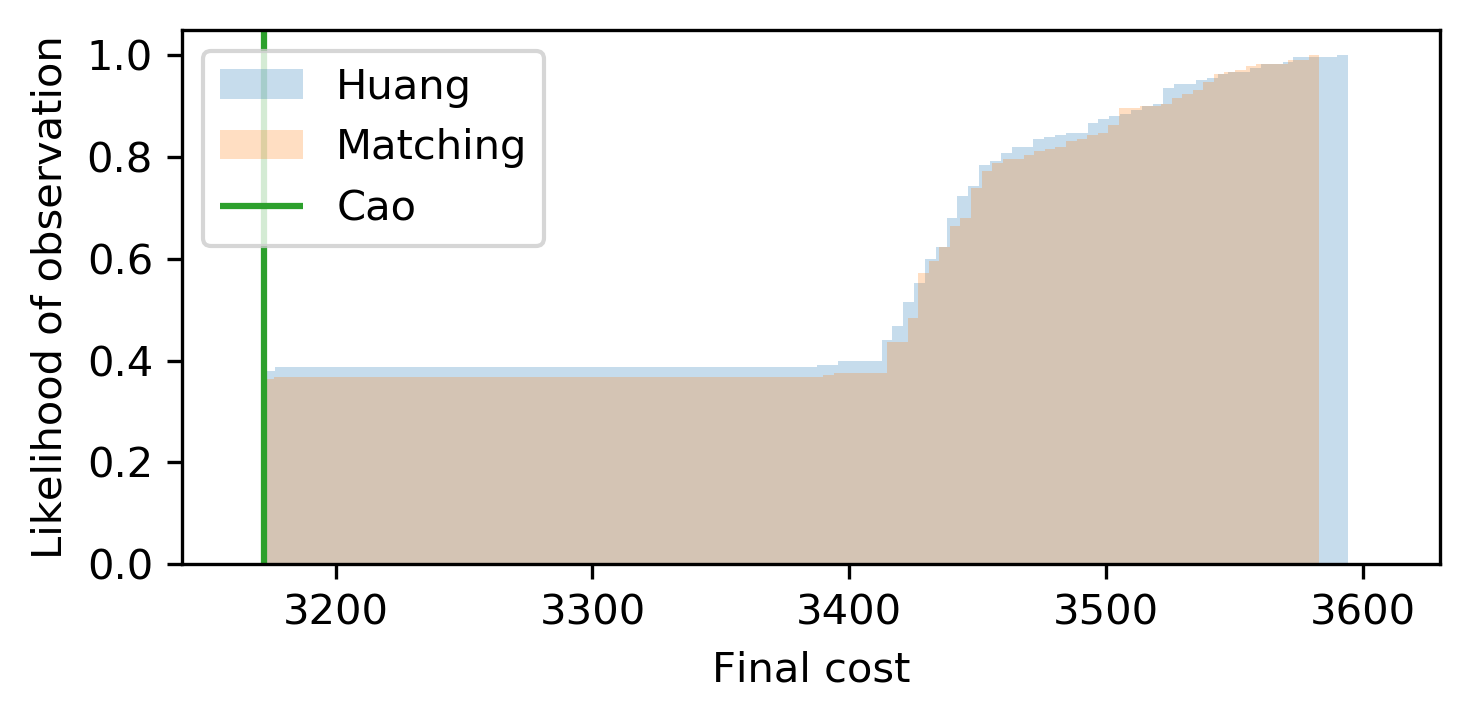

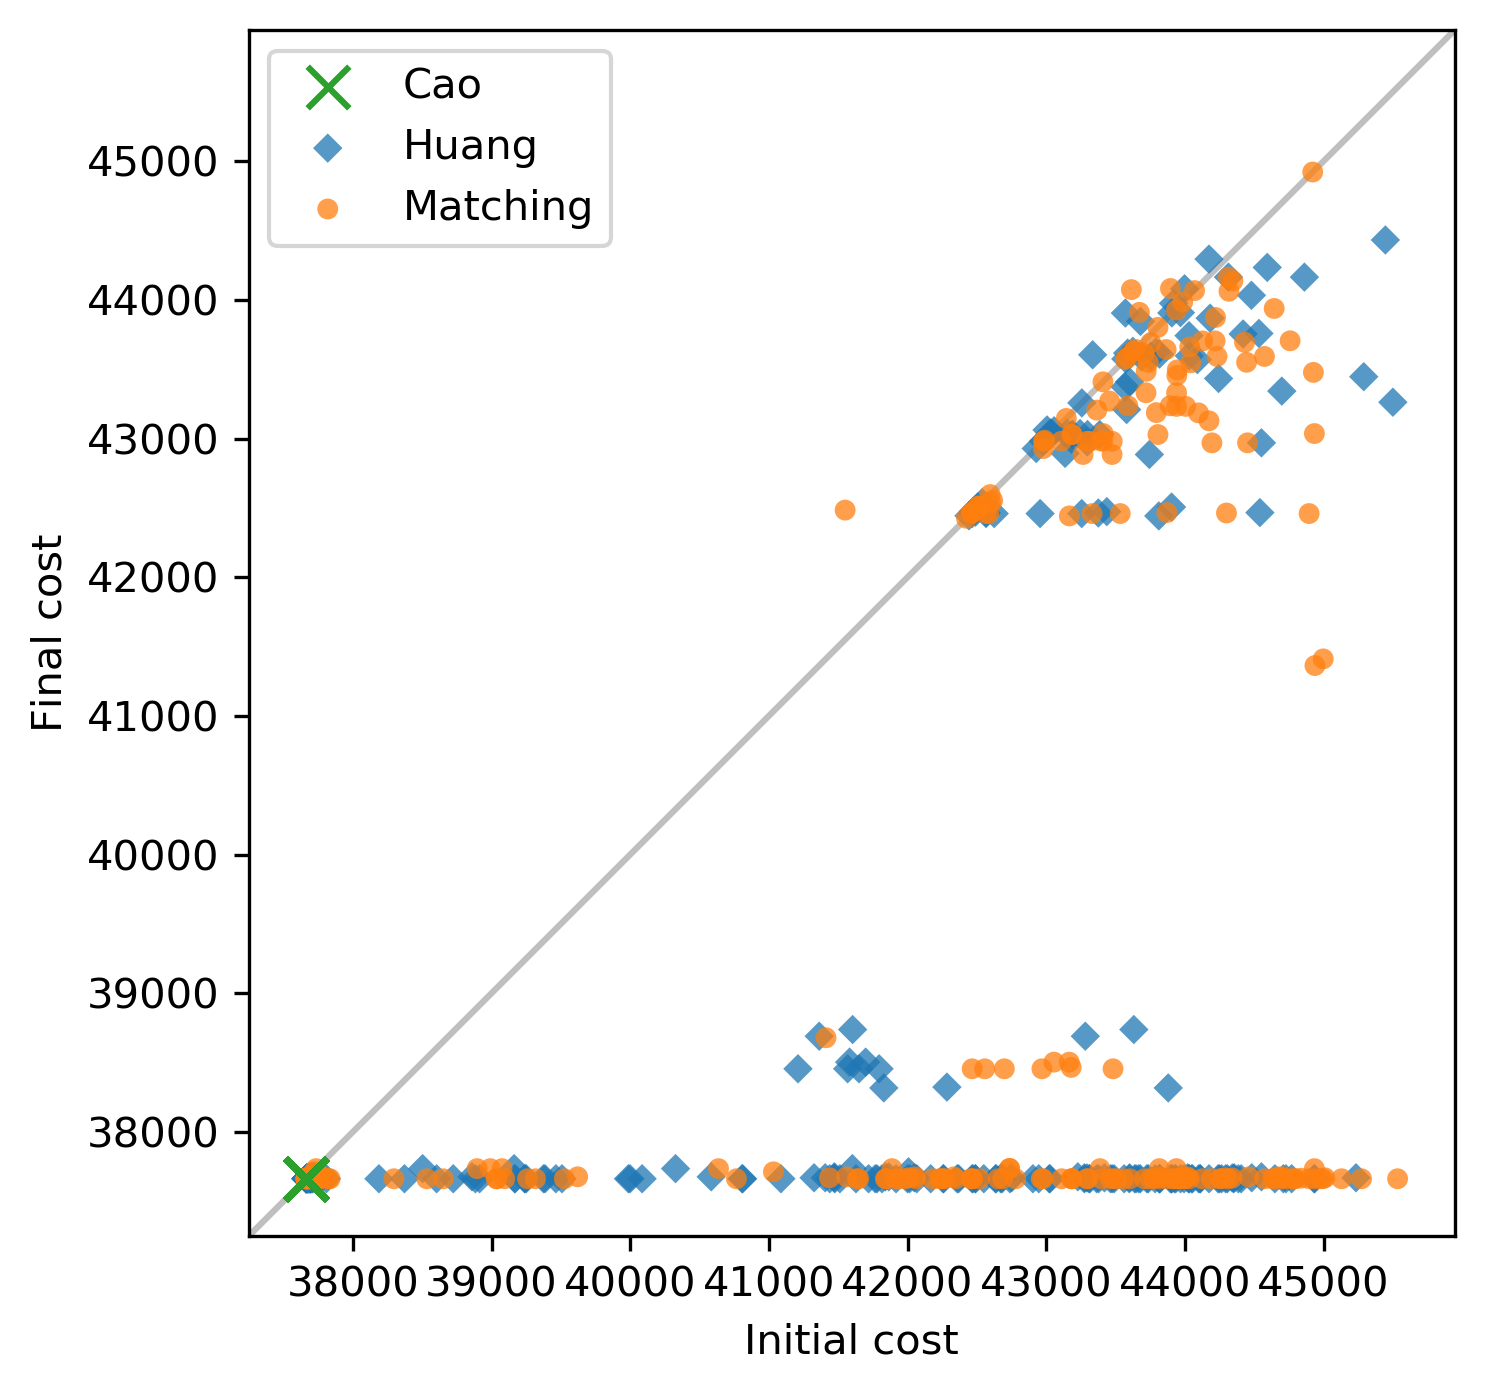

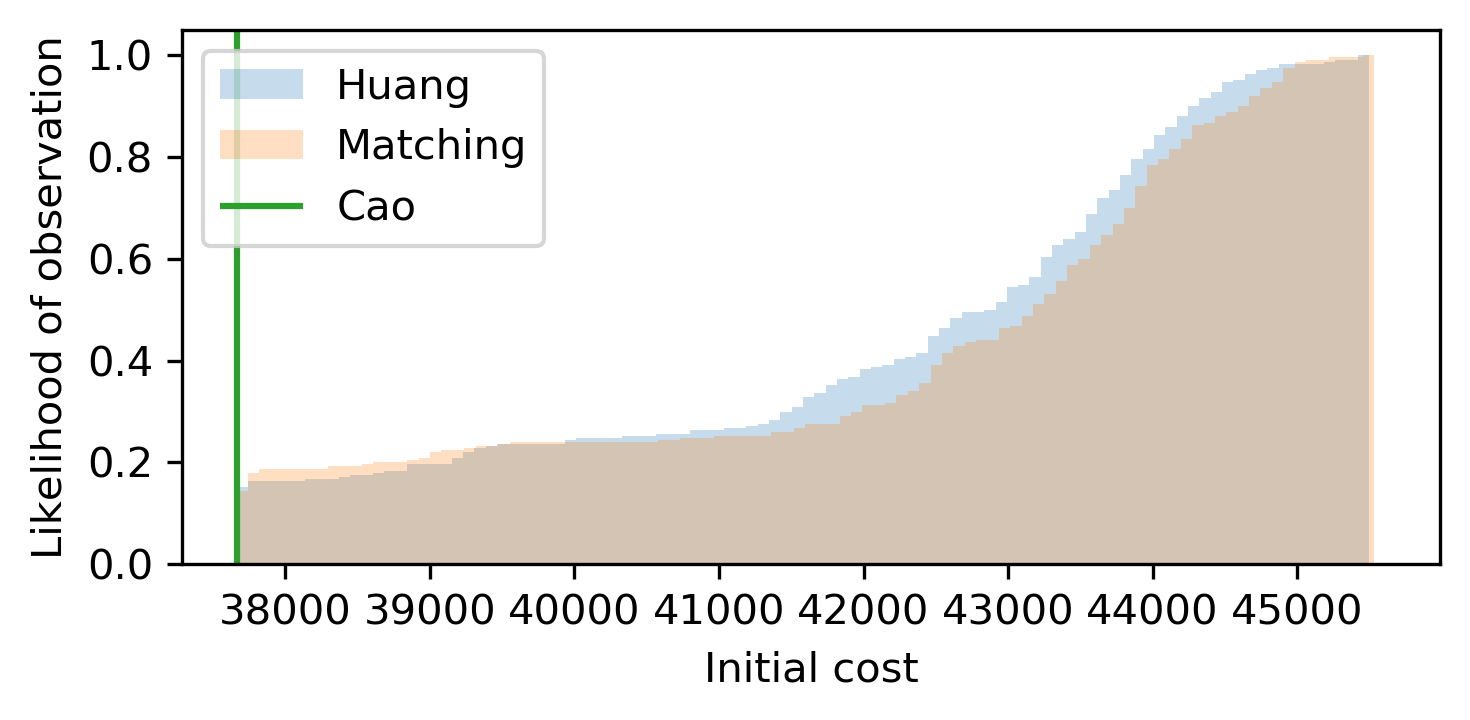

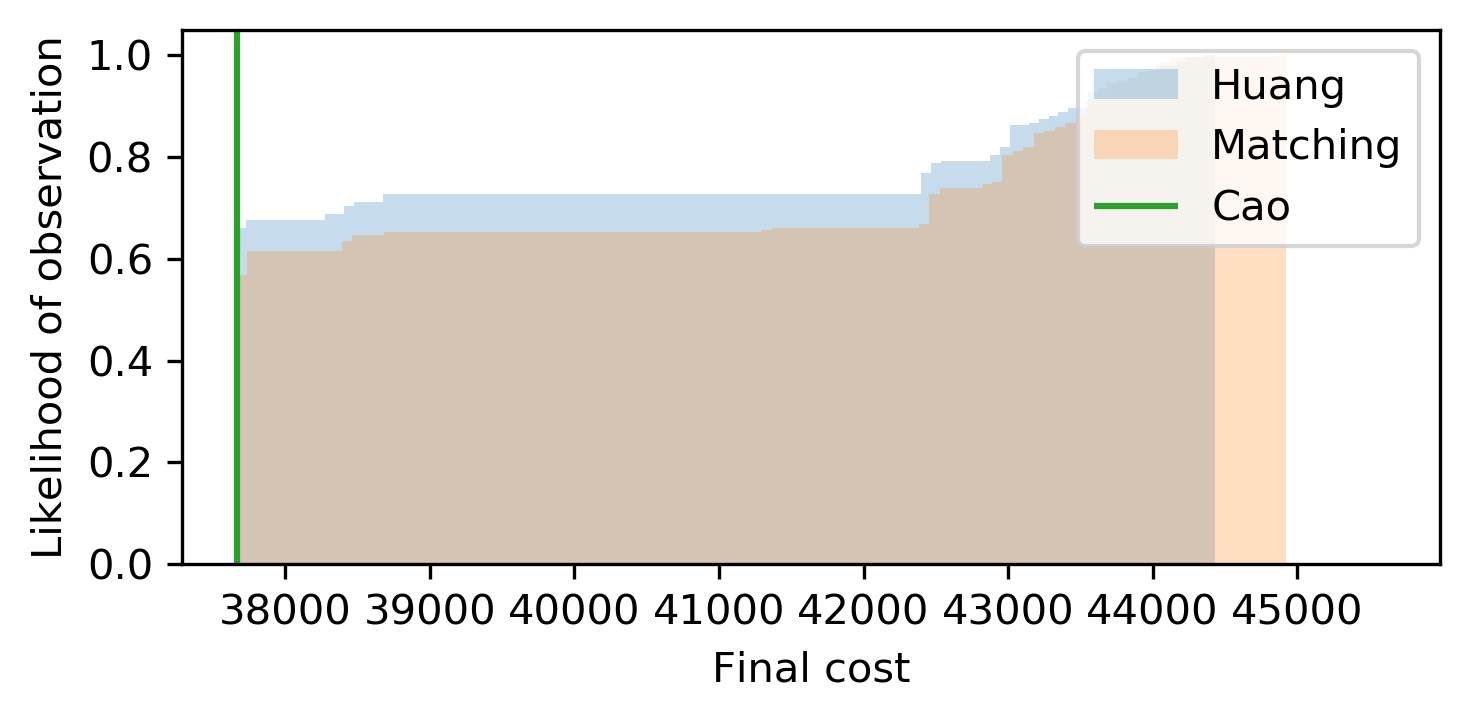

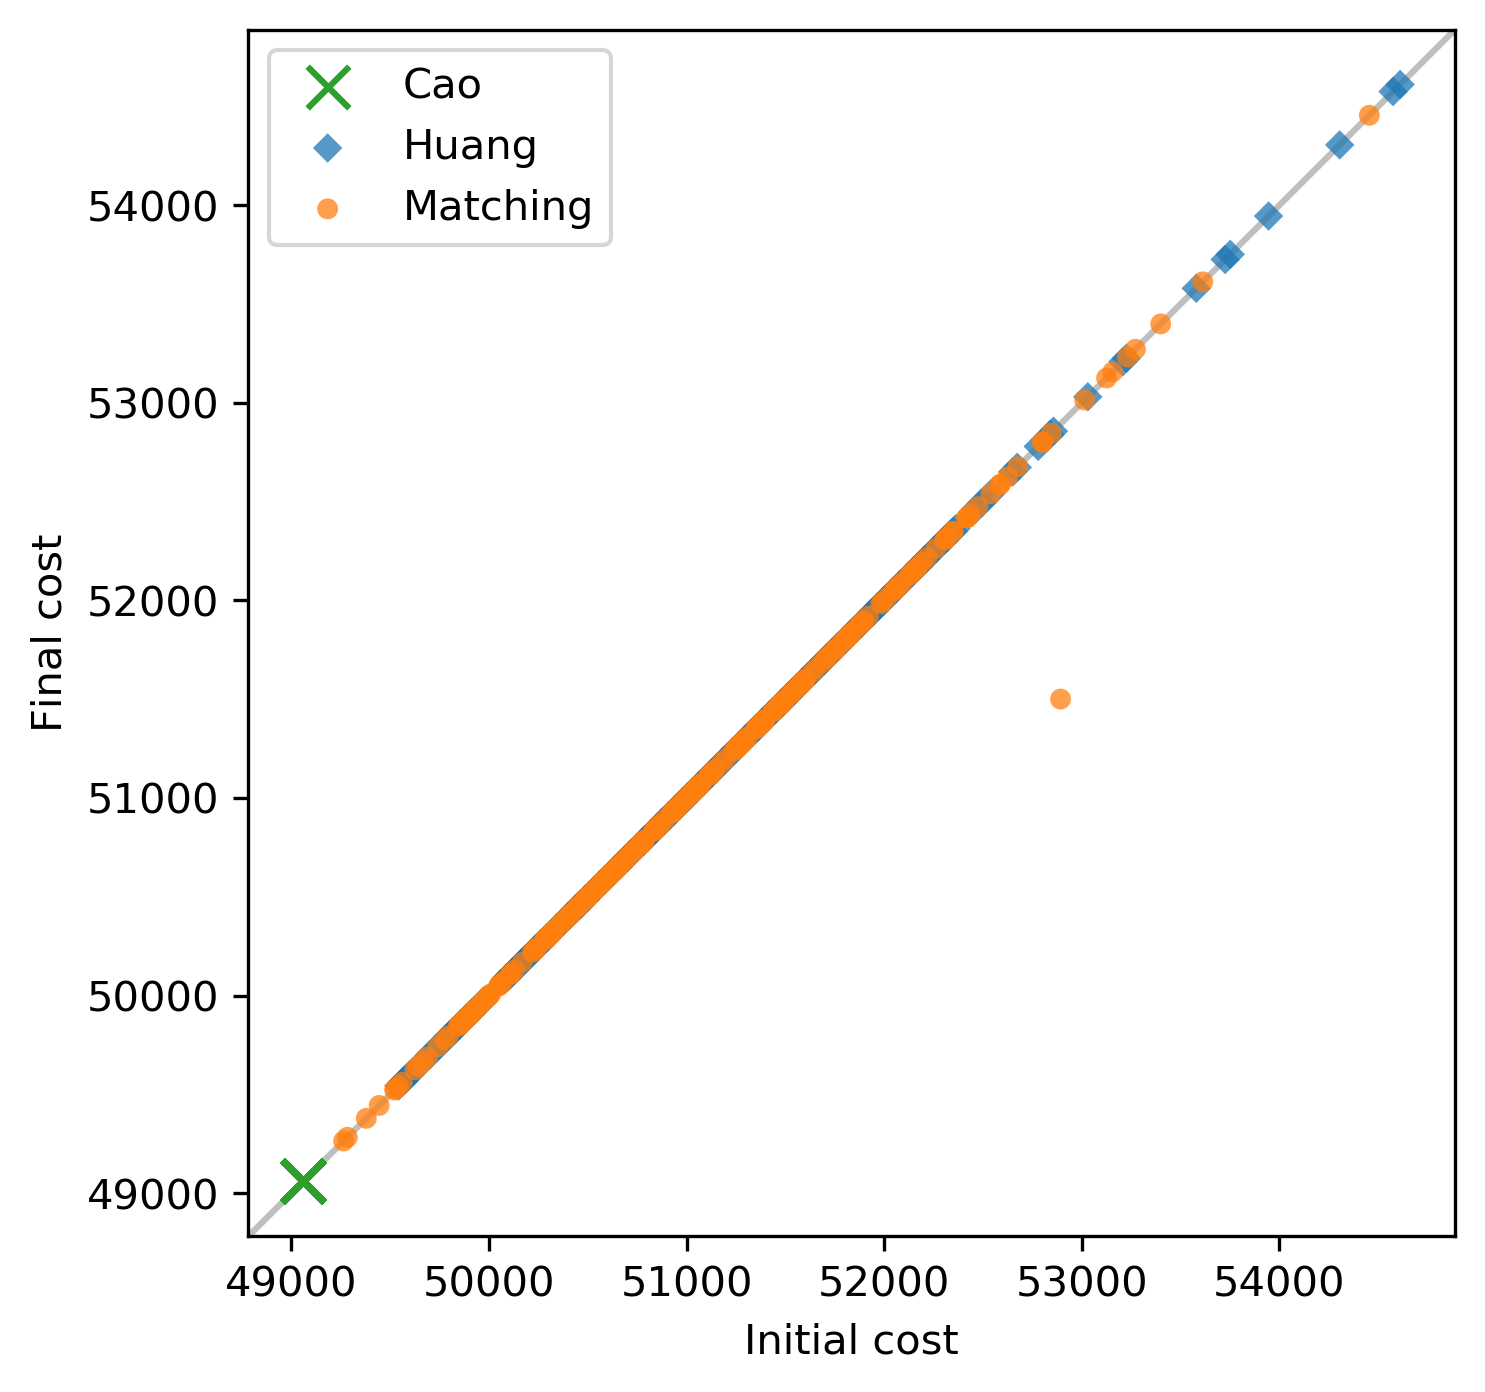

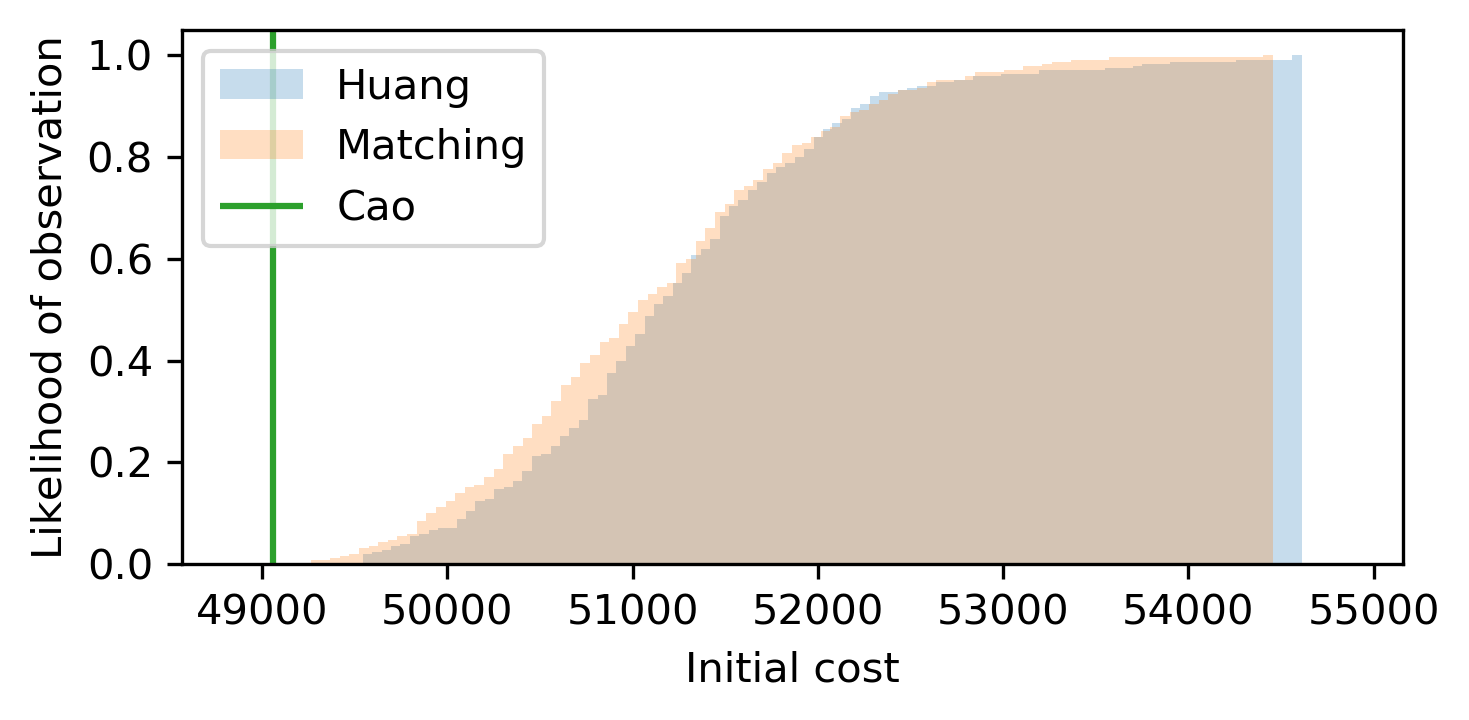

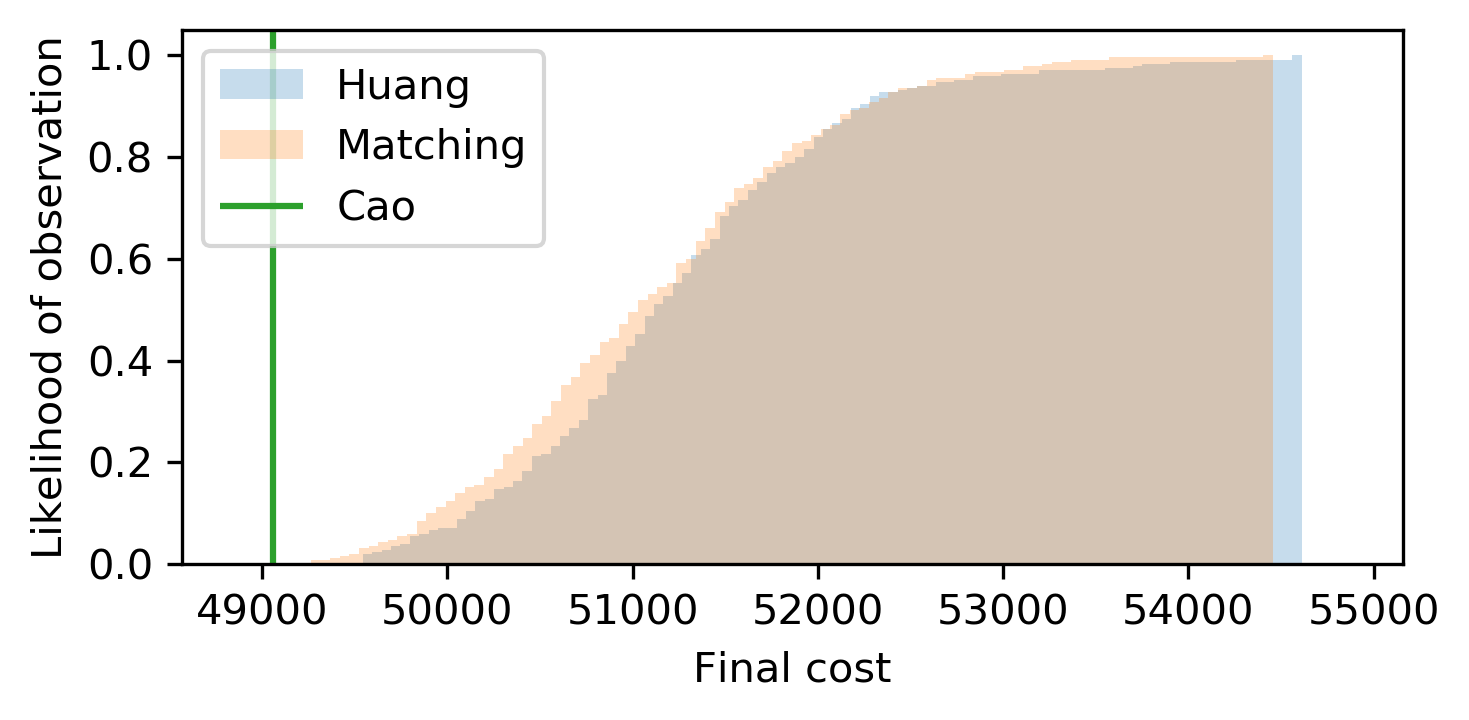

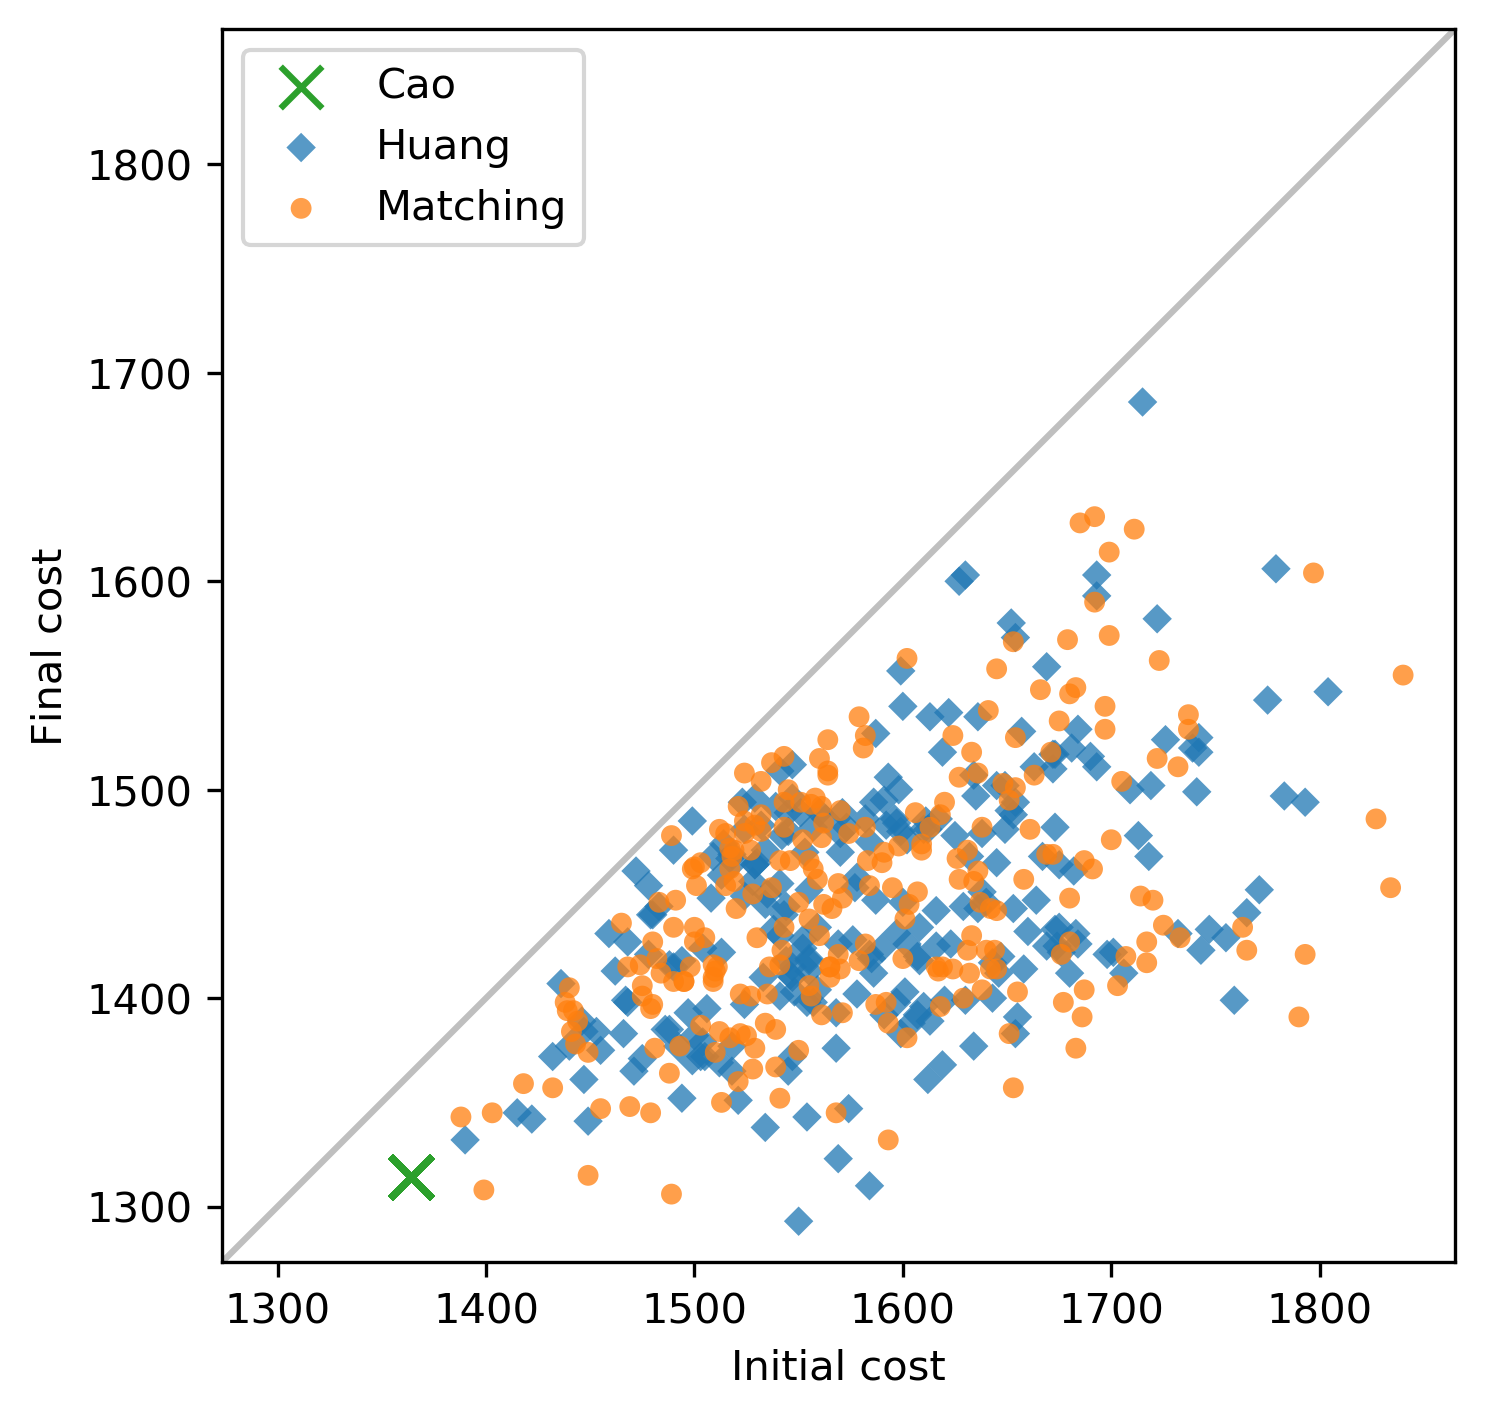

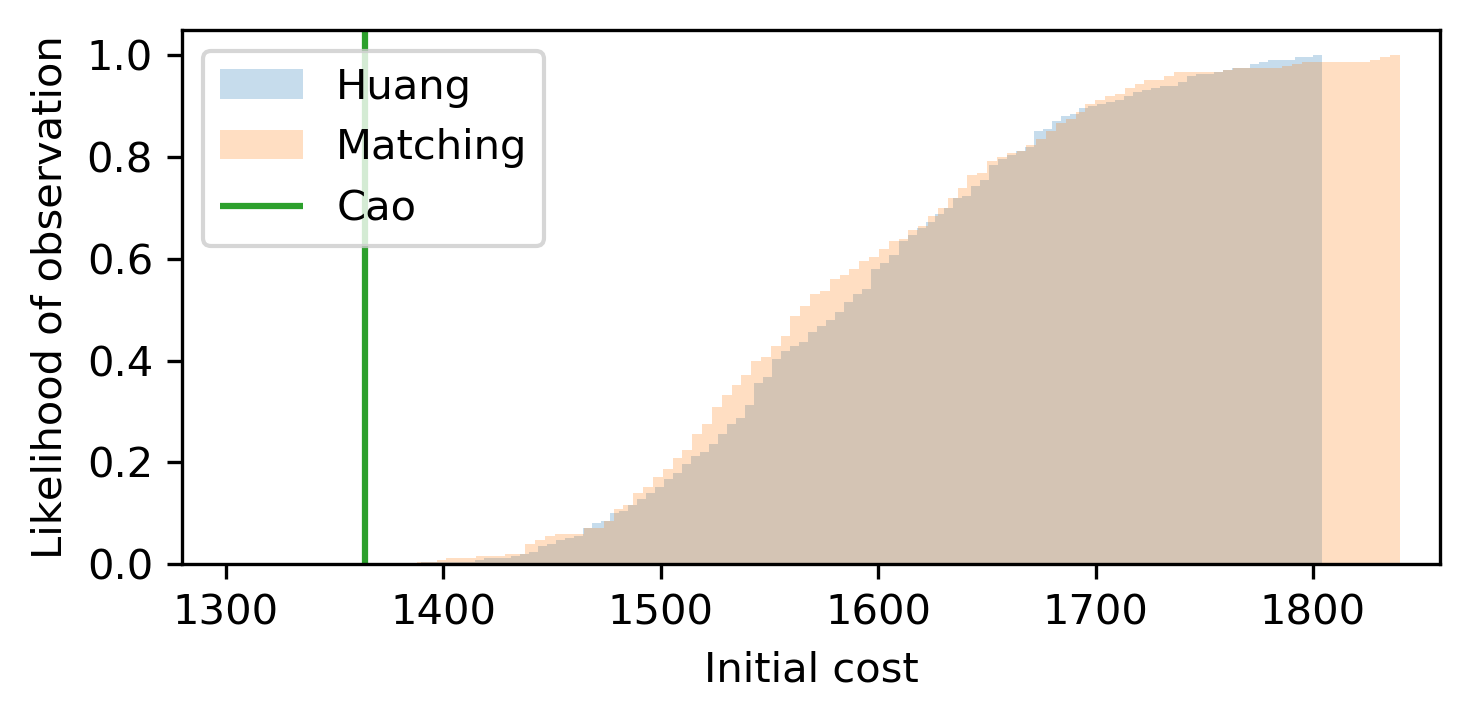

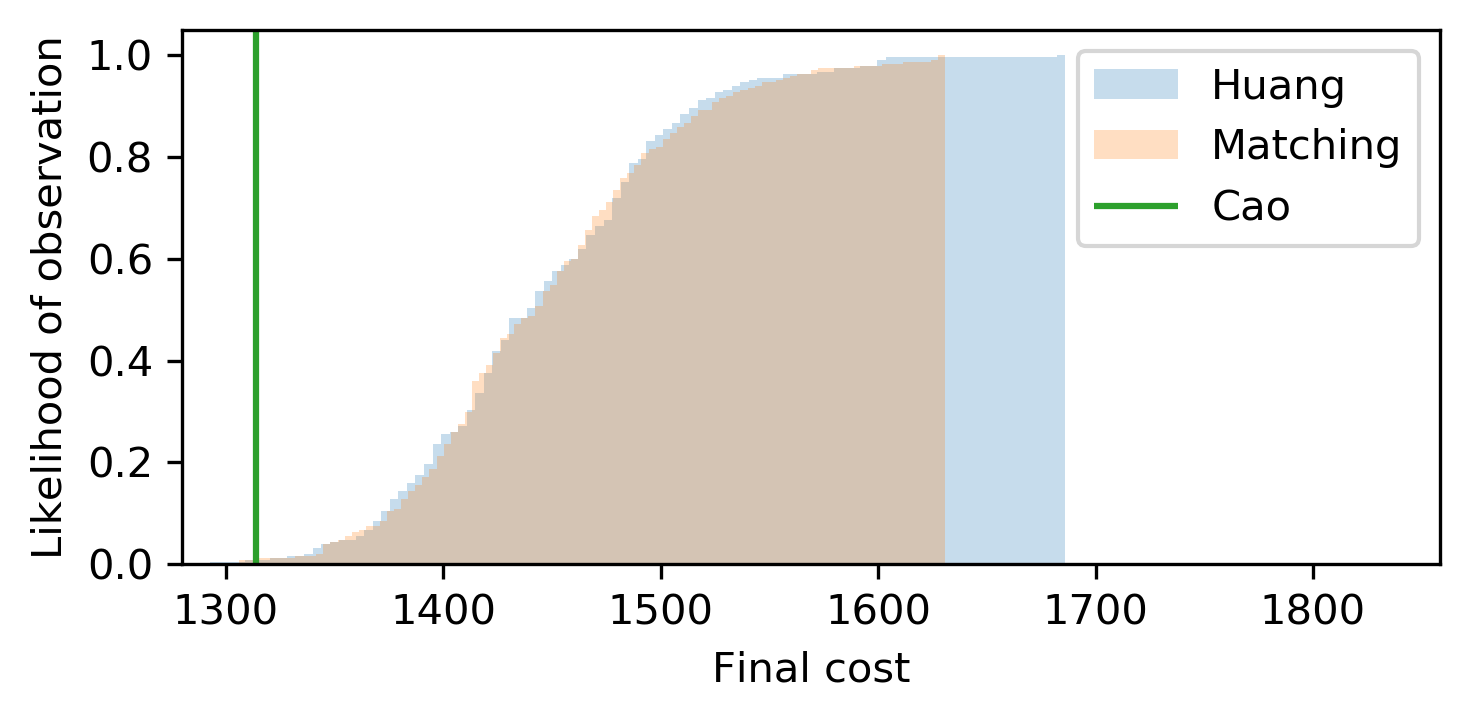

In [8]:
nseeds = 250

with open("../tex/repetitions.tex", "w") as f:
    f.write(str(nseeds))

make_plots("../data/knee/", 3, 1)
make_plots("../data/nclasses/", 7, 5)
